In [1]:
!apt-get update # Update apt-get repository.
!apt-get install openjdk-8-jdk-headless -qq > /dev/null # Install Java.
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz # Download Apache Sparks.
!tar xf spark-3.1.1-bin-hadoop3.2.tgz # Unzip the tgz file.
!pip install -q findspark # Install findspark. Adds PySpark to the System path during runtime.

# Set environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

!ls

# Initialize findspark
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [662 kB]
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [1,600 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,313 kB]
Hit:13 http

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark

## 1. Problem satement/About the dataset

**Title:** Mall Customers Dataset

**About:** The Mall Customers dataset contains information about the people visiting the mall. The main objective of this analysis is to group or seggregate the customers according to their behaviours and spending patterns, by collecting insights from the data given.
A direct application of this type of analysis can be in the strategies to be introduced by a marketing or sales team in targeting specific products to specific groups of customers.

**Dataset:**
This dataset consists of 5 columns:
  1. Customer ID: Unique ID assigned to each customer
  2. Gender: Gender of each customer
  3. Age: Age of each customer
  4. Annual Income: Annual income of the customer
  5. Spending Score: This is a score assigned by the mall to each customer, it's value assigned between 1 and 100


In [5]:
import pandas as pd

## 2. Data reading and exploration
This part of the analysis is for reading/loading the dataset.

In [6]:
#READING CSV FORMAT
df = spark.read.csv("/content/Mall_Customers.csv", header=True, inferSchema=True)

#READING JSON FORMAT
df_json = spark.read.json("/content/Mall_Customers.json")

#READING XLSX FORMAT
df_excel = pd.read_excel("/content/Mall_Customers.xlsx")

df_excel = spark.createDataFrame(df_excel)

#READING PARQUET FORMAT
df_parquet = spark.read.parquet("/content/Mall_Customers.parquet")


/content/spark-3.1.1-bin-hadoop3.2/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [7]:
df.printSchema()

root
 |-- CustomerID: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Annual Income (k$): integer (nullable = true)
 |-- Spending Score (1-100): integer (nullable = true)



In [33]:
df = df.withColumnRenamed("Annual Income (k$)", "AnnualIncome")
df = df.withColumnRenamed("Spending Score (1-100)", "SpendingScore")

df.printSchema()

root
 |-- CustomerID: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- AnnualIncome: integer (nullable = true)
 |-- SpendingScore: integer (nullable = true)



## 3. Performing SQL queries on the dataset to gather insights

In [36]:
df.createOrReplaceGlobalTempView("customers")

##### 1. Count the number of customers in each gender category

In [37]:
query = "SELECT Gender, COUNT(CustomerID) AS Number_of_Customers FROM customers GROUP BY Gender ORDER BY Number_of_Customers DESC;"
result = spark.sql(query)
result.show()

+------+-------------------+
|Gender|Number_of_Customers|
+------+-------------------+
|Female|                112|
|  Male|                 88|
+------+-------------------+



##### 2. Count the total number of customers

In [42]:
query = "SELECT COUNT(*) AS Total_Customers FROM customers;"

result = spark.sql(query)
result.show()

+---------------+
|Total_Customers|
+---------------+
|            200|
+---------------+



##### 3. Find the average age of all the customers

In [44]:
query = "SELECT AVG(Age) AS Average_Age FROM customers;"

result = spark.sql(query)
result.show()

+-----------+
|Average_Age|
+-----------+
|      38.85|
+-----------+



##### 4. Determine the highest spending score

In [51]:
query = 'SELECT MAX(`Spending Score (1-100)`) AS Highest_Spending_Score FROM customers;'
result = spark.sql(query)
result.show()

+----------------------+
|Highest_Spending_Score|
+----------------------+
|                    99|
+----------------------+



##### 5. Identify the gender with the highest average annual income

In [52]:
query = "SELECT Gender, AVG(`Annual Income (k$)`) AS Average_Annual_Income FROM customers GROUP BY Gender ORDER BY Average_Annual_Income DESC LIMIT 1;"

result = spark.sql(query)
result.show()

+------+---------------------+
|Gender|Average_Annual_Income|
+------+---------------------+
|  Male|    62.22727272727273|
+------+---------------------+



## 4. Correlation Analysis

In [53]:
from pyspark.sql.functions import corr

##### 1. Correlation between annual income of the customer and the spending score

In [56]:
correlation = df.corr("AnnualIncome", "SpendingScore")
print("Correlation Score (AnnualIncome vs. SpendingScore):", correlation)

Correlation Score (AnnualIncome vs. SpendingScore): 0.009902848094037497


##### 2. Correlation between age and spending score of the customer

In [58]:
correlation = df.corr("Age", "SpendingScore")
print("Correlation Score (Age vs. SpendingScore):", correlation)

Correlation Score (Age vs. SpendingScore): -0.32722684603909025


##### 3. Correlation between age and annual income of customer

In [59]:
correlation = df.corr("Age", "AnnualIncome")
print("Correlation Score (Age vs. AnnualIncome):", correlation)

Correlation Score (Age vs. AnnualIncome): -0.01239804273606026


**Interpreting the correlation coefficient:**

Strength:
*   Absolute value closer to 1: Stronger correlation
*   Absolute value closer to 0: Weaker correlation


Direction:


*   Positive value: Positive correlation (variables tend to increase or decrease together)
*   Negative value: Negative correlation (variables tend to move in opposite directions)




## 5. Data Analysis

In [60]:
from pyspark.sql.functions import col, count, mean, stddev, min, max

##### 1. Summary statistics for numerical columns

In [61]:
df.select(col("Age"), col("AnnualIncome"), col("SpendingScore")).describe().show()

+-------+-----------------+-----------------+------------------+
|summary|              Age|     AnnualIncome|     SpendingScore|
+-------+-----------------+-----------------+------------------+
|  count|              200|              200|               200|
|   mean|            38.85|            60.56|              50.2|
| stddev|13.96900733155888|26.26472116527124|25.823521668370173|
|    min|               18|               15|                 1|
|    max|               70|              137|                99|
+-------+-----------------+-----------------+------------------+



##### 2. Descriptive statistics by groups (Male vs. Female)

In [64]:
df.groupBy("Gender").agg(mean("Age"), mean("AnnualIncome"), mean("SpendingScore")).show()

+------+------------------+-----------------+------------------+
|Gender|          avg(Age)|avg(AnnualIncome)|avg(SpendingScore)|
+------+------------------+-----------------+------------------+
|Female|38.098214285714285|            59.25|51.526785714285715|
|  Male| 39.80681818181818|62.22727272727273| 48.51136363636363|
+------+------------------+-----------------+------------------+



##### 3. Frequency distribution of gender

In [65]:
df.groupBy("Gender").count().show()

+------+-----+
|Gender|count|
+------+-----+
|Female|  112|
|  Male|   88|
+------+-----+



##### 4. Skewness and kurtosis of age column

In [66]:
from pyspark.sql.functions import skewness, kurtosis

In [67]:
df.select(skewness("Age"), kurtosis("Age")).show()

+-------------------+-------------------+
|      skewness(Age)|      kurtosis(Age)|
+-------------------+-------------------+
|0.48191947090957277|-0.6847513947723258|
+-------------------+-------------------+



**Interpretation**


> These measure the asymmetry and "tailedness" of the data distribution.



## 6. Model building (Clustering)

Clustering customers based on their annual income and spending score.

##### 1. Import necessary libraries

In [83]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import DoubleType

##### 2. Pre-processing the date (Casting columns to appropriate data types)

In [84]:
df = df.withColumn("AnnualIncome", col("AnnualIncome").cast(DoubleType()))
df = df.withColumn("SpendingScore", col("SpendingScore").cast(DoubleType()))

##### 3. Handling of missing values

In [85]:
df = df.fillna(0, subset=["AnnualIncome", "SpendingScore"])

##### 4. Create a feature vector

In [ ]:
assembler = VectorAssembler(inputCols=["AnnualIncome", "SpendingScore"], outputCol="features")
df = assembler.transform(df)

##### 5. Train the KMeans model

In [87]:
kmeans = KMeans(k=5)
model = kmeans.fit(df)

##### 6. Assigning cluster labels

In [88]:
predictions = model.transform(df)
predictions.show()


+----------+------+---+------------+-------------+------------------+----------------------+-----------+----------+
|CustomerID|Gender|Age|AnnualIncome|SpendingScore|Annual Income (k$)|Spending Score (1-100)|   features|prediction|
+----------+------+---+------------+-------------+------------------+----------------------+-----------+----------+
|         1|  Male| 19|        15.0|         39.0|              15.0|                  39.0|[15.0,39.0]|         0|
|         2|  Male| 21|        15.0|         81.0|              15.0|                  81.0|[15.0,81.0]|         1|
|         3|Female| 20|        16.0|          6.0|              16.0|                   6.0| [16.0,6.0]|         0|
|         4|Female| 23|        16.0|         77.0|              16.0|                  77.0|[16.0,77.0]|         1|
|         5|Female| 31|        17.0|         40.0|              17.0|                  40.0|[17.0,40.0]|         0|
|         6|Female| 22|        17.0|         76.0|              17.0|   

**Visualizing the model**

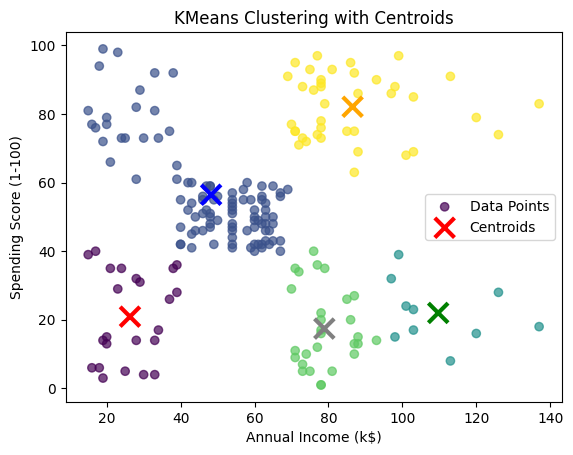

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pandas_df = predictions.toPandas()

centroids = model.clusterCenters()

centroids = np.array(centroids)

plt.scatter(pandas_df["AnnualIncome"], pandas_df["SpendingScore"], c=pandas_df["prediction"], marker="o", alpha=0.7, label="Data Points")

plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=200, linewidths=3, c=["red", "blue", "green", "grey", "orange"] , label="Centroids")

plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.title("KMeans Clustering with Centroids")
plt.legend()
plt.show()



## 7. Model Evaluation

**Silhouette Score**


> This measures the average similarity of data points within a cluster compared to their similarity with data points in other clusters. Higher scores indicate better clustering.



In [95]:
from pyspark.ml.evaluation import ClusteringEvaluator

In [96]:
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette score: {silhouette}")

Silhouette score: 0.6222899451645938
